# Prepare dataset for the training
To train the model we are going to use the dataset: 5000 Youtube Spam/Not Spam dataset
This dataset is accesible for free using the following link: https://www.kaggle.com/datasets/madhuragl/5000-youtube-spamnot-spam-dataset

This notebook was runned using google colabs. It is possible that minor tweeks are necesary to run it locally or using other online services.

In [1]:
# Controls to decide which part of the code are executed
training = 0  # First model training
checkDataset = 0 #Improve the dataset using the first model
training2 = 1 # Training final model

In [2]:
%%capture
!pip install sentencepiece

In [3]:
%%capture
!pip install torch
!pip install protobuf==3.20.1
!pip install transformers==4.28.0
!pip install datasets
!pip install evaluate

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import pandas as pd
path = './training/dataset'
path = '/content/gdrive/MyDrive/youtubeAPI/training/dataset'
df= pd.read_csv(path+'/5000YTcomments.csv', encoding='cp1252')

In [6]:
df.head()

Name                                            Comment  \
0        Taofeekat  &lt;????i make my first million investing in f...   
1  Angelina Jordan  &lt;?l will forever be indebted to you I will ...   
2    Fernandez Joe  <b>????I recommend a professional forex/Bitcoi...   
3   Jessica  Billy  I think I’m blessed because if not I wouldn’t ...   
4      Allison Zar  <b>I recommend a professional  broker to you g...   

                   Time  Likes  Reply Count  Spam  
0  2022-09-28T02:08:55Z     30           30     1  
1  2022-09-23T05:26:48Z      0            0     1  
2  2022-09-20T12:56:30Z      5            2     1  
3  2022-09-17T20:20:24Z     21           34     1  
4  2022-09-05T09:19:30Z     19           27     1

In [7]:
df.describe(include='object')

Name                                            Comment  \
count            5000                                               5000   
unique           4411                                               4673   
top     Charlie Steve  how do i access my coins again with exodus wal...   
freq                9                                                 27   

                        Time  
count                   5000  
unique                  4967  
top     2021-06-04T21:41:19Z  
freq                       5

We prepared the data to keep only two columns, one representative of all relevant information of the comment, and the second one to check if it is spam or not. The information will be:

- Likes
- replyCount
- Text

At this state we are only going to use the message to see if it is spam or not, but we already prepare the data to can iterate in the future with more complex model. The idea will be concatenated in a single string to can be procesed by the NLP model. Special separators must be incluided so the model can understand and separate the information. The formating of a message will be:

**nLikes: 1 #nReplys: 1 #Text: sample text**

first attemps didn't show a significant improvement on the model, so we keep the simple version until new iterations in the future.

In [8]:
#df['input'] = ('#nLikes: ' + df.Likes.astype(str) + 
#    ' #nReplys: ' + df['Reply Count'].astype(str) + 
#    ' #Text: ' + df.Comment
#)
df['input'] = df.Comment
df = df.drop(['Name', 'Comment', 'Time', 'Likes', 'Reply Count'],axis=1)
df = df.rename(columns={'Spam':'labels'})
df['labels'] = df.labels

In [9]:
df.head()

labels                                              input
0       1  &lt;????i make my first million investing in f...
1       1  &lt;?l will forever be indebted to you I will ...
2       1  <b>????I recommend a professional forex/Bitcoi...
3       1  I think I’m blessed because if not I wouldn’t ...
4       1  <b>I recommend a professional  broker to you g...

To be extra carefull with our training process, we are going to separate a 15% of the dataset to use it as final check. It will be complety separate from the training and play no role on it to avoid possible bias intruduced by me. So the process will use 3 diferent datasets:

- training
- validation
- test

and this test dataset will only be used once the training have been finished as final check.

In [10]:
from sklearn.model_selection import train_test_split

df, test_df = train_test_split(df, test_size=0.15, random_state=42)

## Tokenize
It is needed to tokenize the text the same way than the model we are going to use. For this project we are going to start from a pretrained NLP model using transformers, freely avaible from huggingFaces. A quite suitable model to start with is deberta-v3-small, which can be trained reasonably fast. The are other models already pretrained for spam in hugging faces like twiter-xlm-roberta-crypto-spam, but after some trys, the results were not significantly better, so we decide to start using a standart baseline to make our fine tunning.

In [11]:
if training:
  import torch
  from transformers import AutoTokenizer, AutoModelForSequenceClassification

  model_nm = 'microsoft/deberta-v3-small'
  #model_nm = 'svalabs/twitter-xlm-roberta-crypto-spam'
  tokz = AutoTokenizer.from_pretrained(model_nm)

Transformers expect a dataset object, so we have to transform pandas dataframe to a dataset using the datasets python library

In [12]:
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['labels', 'input', '__index_level_0__'],
    num_rows: 4250
})

NLP model expect numbers (tokens) as input. We define a tokenizer function to tokenize the input text

In [13]:
if training:
    def tok_func(x): return tokz(x["input"], padding="max_length", truncation=False)

In [14]:
if training:
    tok_ds = ds.map(tok_func, batched=True)
    tok_ds

# Split dataset into train, validation and test data

In [15]:
if training:
    dds = tok_ds.train_test_split(0.25, seed=42)
    dds

# Training

For the training process we have to decide the parameters for it. In this case this is done by tryal error depending on the hardware and trying to avoid overfitting.

In [16]:
if training:
    from transformers import TrainingArguments, Trainer

    # Batch size is depending on the gpu to run the trainign quicker
    bs = 8

    # epochs are the number of cycles that we are going to train the model
    epochs = 2

    # The learning rate indicates how much the model can vary on each epoch
    lr = 2e-5

In [17]:
if training:    
    def corr(x,y): return np.corrcoef(x,y)[0][1]
    def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [18]:
import numpy as np
from datasets import load_metric
if training:
  metric = load_metric("accuracy")
  def compute_metrics(eval_pred):
      logits, labels = eval_pred
      predictions = np.argmax(logits, axis=-1)
      return metric.compute(predictions=predictions, references=labels)

In [19]:
if training:
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
        evaluation_strategy="epoch", per_device_train_batch_size=bs, fp16=True, 
        per_device_eval_batch_size=bs*2, num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [20]:
if training: 
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)
    trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=compute_metrics)

In [21]:
if training:
  trainer.train()

# Checking the model

Lets take a look on how the results of the model looks like. We will plot the probability from the model of being a scam message. Red cross will show false scam positives, while black triangles will show a false negative.

In [22]:
if training:
  preds = trainer.predict(dds['test'])
  test = preds.predictions.argmax(-1)-preds.label_ids
  index1 = np.where(test < 0)
  index2 = np.where(test > 0)

In [23]:
import matplotlib.pyplot as plt

if training:
  percent = torch.sigmoid(torch.from_numpy(preds.predictions.astype(float)))
  tmp = percent[:,0]
  x = np.arange(0, len(tmp))

  # Set a line for confidence that is scam
  conf = 0.8

  plt.scatter(x, tmp, alpha=0.5)
  plt.plot([x[0], x[-1]], [conf, conf], 'k-', color = 'r')
  #plt.plot([x[0], x[-1]], [-conf, -conf], 'k-', color = 'r')
  plt.scatter(list(index1), list(tmp[index1]),color='r', marker='x')
  plt.scatter(list(index2), list(tmp[index2]),color='k', marker='^')

Lets take a look on how do the wrong predictions looks like

In [24]:
if training:
    print("===================================================================================================")
    print("False Positives")
    print("===================================================================================================")
    for i in index2[0][:]:
        temp = dds['test']['input_ids'][i]
        print('Scam %: '+str(float(percent[i][1])), 'Text: '+tokz.decode(temp))
    
    print("===================================================================================================")
    print("False Negatives")
    print("===================================================================================================")
    for i in index1[0][:]:
        temp = dds['test']['input_ids'][i]
        print('Scam %: '+str(float(percent[i][1])), 'Text: '+tokz.decode(temp))

Most of the messages are clearly scam even thought they were incorrectly labeled in the dataset. The ones that could be or not scam have a not so hight probability, this indicates that the model actually perform better than what the metric suggest, and also that some clear on the Dataset could improve it even further. On false negatives, it actually seems that none of them is spam and the prediction was right.

# Saving the fine tunned model to be used for the project

In [25]:
import os
if training:
    try:
      os.mkdir('/content/gdrive/MyDrive/youtubeAPI/model')
    except:
      pass
    trainer.save_model("/content/gdrive/MyDrive/youtubeAPI/model")

# Improve dataset

We are going to use the already trained model to improve our dataset and then train a new one.

## Load and test of the fine tunned model

In [26]:
if checkDataset: 
  import torch
  from transformers import AutoTokenizer, AutoModelForSequenceClassification

  finetuned = '/content/gdrive/MyDrive/youtubeAPI/model2'
  tokenizer = AutoTokenizer.from_pretrained(finetuned)
  tokenizer

In [27]:
if checkDataset: 
  from transformers import TextClassificationPipeline

  model_ = AutoModelForSequenceClassification.from_pretrained(finetuned)
  pipe = TextClassificationPipeline(model=model_, tokenizer=tokenizer, top_k = None, device=0)

In [28]:
if checkDataset: 
  sequences = ["I'm glad I got into trading when I did because it was a turning point for me financially, it was my best decision. ",'good video']
  result = pipe(sequences)[0:]
  result

## Improving the dataset

We are going to use the already petrained model to correct the errors that were on the dataset, and generate a better new one to train the final model. First step is to load the dataset as we did for the first training.

In [29]:
if checkDataset: 
  import pandas as pd
  path = '/content/gdrive/MyDrive/youtubeAPI/training/dataset'
  df= pd.read_csv(path+'/5000YTcomments.csv', encoding='cp1252')
  df['input'] = df.Comment
  df = df.drop(['Name', 'Comment', 'Time', 'Likes', 'Reply Count'],axis=1)
  df = df.rename(columns={'Spam':'labels'})
  df['labels'] = df.labels

Tnstead of the labels, we will return the percentage of certainty that the model has that the comment is spam. In this case we will do for all the data inside the dataset.

In [30]:
if checkDataset: 
  testing = list(df.input.values)

  result = pipe(testing[0:])
  label_map = {'LABEL_1': 1, 'LABEL_0': 0}
  test = [label_map[elem[0]['label']] for elem in result]
  test2 = [abs(label_map[elem[1]['label']]-elem[0]['score']) for elem in result]

In [31]:
if checkDataset: 
  new_df = df.copy()
  new_df['prediction'] = test2
  new_df['error']=abs(new_df.labels-new_df.prediction)

In this small script we show one by one the elements with more error to check manually what is the real label, and in case it is wrong, correct the dataset so the next generation of the model is trained with corrected data. There are some obvious mistakes in the labelling from the dataset, but others are not so selfevidents. In this case we will priorizate freedom of speech and if it is not so clear that the message is spam for me, I will mark it as not spam.

In [32]:
if checkDataset: 
  from IPython.display import clear_output

  # Sort the DataFrame by the error column in descending order
  new_df_sorted = new_df.sort_values(by='error', ascending=False)

  # Iterate through the rows of the sorted DataFrame
  for index, row in new_df_sorted.iterrows():
      # Print the current row
      clear_output(wait=True)
      print("Row Index:", index)
      print("text:", row['input'])
      print("Label:", row['labels'])
      print("Error:", row['error'])
      
      # Prompt user for manual label change0

      change_label = input("Do you want to change the label? (y/n/finish): ")
      
      # Check if the user wants to change the label
      if change_label.lower() == 'y':
          new_label = input("Enter the new label: ")
          # Update the label in the 1DataFrame
          new_df.at[index, 'labels'] = new_label
      elif change_label.lower() == 'finish':
          break

After going throught all the messages where the error between prediction and real label was higher than 0.5, we finally save the new we use the rechecked labels to create a new dataset.

In [33]:
if checkDataset: 
  saving_df = pd.read_csv(path+'/5000YTcomments.csv', encoding='cp1252')
  saving_df['Spam'] = new_df['labels']
  saving_df.to_csv(path+'/5000YTcomments_manualCheck.csv', encoding='cp1252', index = False)

# New model

In this section we basically follow the same training process as before, but instead of using the original dataset, we will load our manual validated one.

In [34]:
df = pd.read_csv(path+'/5000YTcomments_manualCheck.csv', encoding='cp1252')
df['input'] = df.Comment
df = df.drop(['Name', 'Comment', 'Time', 'Likes', 'Reply Count'],axis=1)
df = df.rename(columns={'Spam':'labels'})
df['labels'] = df.labels

As before we are going to take away 15% of the dataset so it is not used at all during the training process and we can use it as final check to avoid human bias. (Note this was not used at first iteration becouse even without it, another issues with the dataset appeared)

In [35]:
from sklearn.model_selection import train_test_split

df, test_df = train_test_split(df, test_size=0.05, random_state=42)

In [36]:
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df)

In [37]:
if training2:
  import torch
  from transformers import AutoTokenizer, AutoModelForSequenceClassification

  model_nm = 'microsoft/deberta-v3-small'
  tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
if training2:
    def tok_func(x): return tokz(x["input"], padding="max_length", truncation=False)

In [39]:
if training2:
    tok_ds = ds.map(tok_func, batched=True)
    dds = tok_ds.train_test_split(0.25, seed=35)

Map:   0%|          | 0/4750 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.


In [40]:
if training2:
    from transformers import TrainingArguments, Trainer

    # Batch size is depending on the gpu to run the trainign quicker
    bs = 8

    # epochs are the number of cycles that we are going to train the model
    epochs = 2

    # The learning rate indicates how much the model can vary on each epoch
    lr = 4e-5

In [41]:
if training2:    
    def corr(x,y): return np.corrcoef(x,y)[0][1]
    def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [42]:
import numpy as np
from datasets import load_metric
if training2:
  metric = load_metric("accuracy")
  def compute_metrics(eval_pred):
      logits, labels = eval_pred
      predictions = np.argmax(logits, axis=-1)
      return metric.compute(predictions=predictions, references=labels)

<ipython-input-42-be0a3608e730>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [43]:
if training2:
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
        evaluation_strategy="epoch", per_device_train_batch_size=bs, fp16=True, 
        per_device_eval_batch_size=bs*2, num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [44]:
if training2: 
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)
    trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=compute_metrics)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [45]:
if training2:
  trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The new Accuracy is above 96% and it can achive 98% depending on the training run. Quite impresive and a hudge improvement compared with the previous model. Lets take a look on how the results of the model looks like. We will plot the probability from the model of being a scam message. Red cross will show false scam positives, while black triangles will show a false negative.

In [46]:
if training2:
  preds = trainer.predict(dds['test'])
  test = preds.predictions.argmax(-1)-preds.label_ids
  index1 = np.where(test < 0)
  index2 = np.where(test > 0)

<ipython-input-47-2be12f5d5e01>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0], x[-1]], [conf, conf], 'k-', color = 'r')


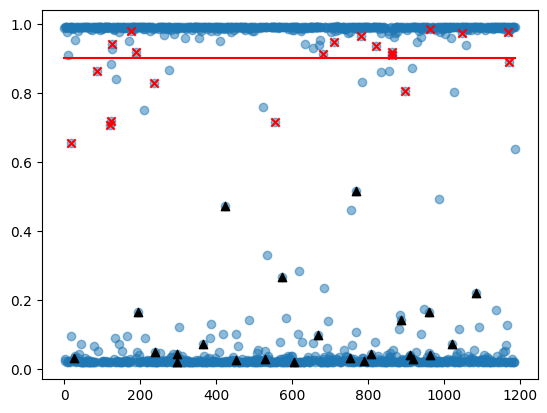

In [47]:
import matplotlib.pyplot as plt

if training2:
  percent = torch.sigmoid(torch.from_numpy(preds.predictions.astype(float)))
  tmp = percent[:,0]
  x = np.arange(0, len(tmp))

  # Set a line for confidence that is scam
  conf = 0.9

  plt.scatter(x, tmp, alpha=0.5)
  plt.plot([x[0], x[-1]], [conf, conf], 'k-', color = 'r')
  #plt.plot([x[0], x[-1]], [-conf, -conf], 'k-', color = 'r')
  plt.scatter(list(index1), list(tmp[index1]),color='r', marker='x')
  plt.scatter(list(index2), list(tmp[index2]),color='k', marker='^')

Lets take a look on how do the wrong predictions looks like

In [48]:
if training2:
    print("===================================================================================================")
    print("False Positives")
    print("===================================================================================================")
    for i in index2[0][:]:
        temp = dds['test']['input_ids'][i]
        print('Scam %: '+str(float(percent[i][1])), 'Text: '+tokz.decode(temp))
    
    print("===================================================================================================")
    print("False Negatives")
    print("===================================================================================================")
    for i in index1[0][:]:
        temp = dds['test']['input_ids'][i]
        print('Scam %: '+str(float(percent[i][1])), 'Text: '+tokz.decode(temp))

False Positives
Scam %: 0.974773174620712 Text: [CLS] I know knowledge is the Right power in our Earth?????? but you are serious power full Ladies I wish you health long life in peace I love you more over[SEP]
Scam %: 0.8609547092195301 Text: [CLS] Chestercoin.moon will be next rocket??[SEP]
Scam %: 0.9606574967357419 Text: [CLS] they call TESLA business bitcoin in 2017 oO[SEP]
Scam %: 0.9649213233571159 Text: [CLS] Guys tell me please a few project with a great potential in the future, like Sushi, Yfi, SpaceSwap. <br>I want to invest[SEP]
Scam %: 0.9816655479104817 Text: [CLS] Content creating is the hardest passive income to get into in general. Basically, you have to have the network of an influencer and that takes years (8 in your case). This is great info for aspiring content creators, I would say there are much better ways to make complete passive income through high apy, diverse assets and etc. These are definitely real ways to make passive income and I appreciate your transpare

Taking a look to the false predictions we can get some conclusions:

1.   Results have improve a lot from previous model.
2.   False negatives seems like actual negatives or kind of in the limit of being spam wich for my personal prespective should be keep as negative. 
3.   False positives are also kind on the limit. Capital letters messages which seems suspicious of being part of a scam conversations, links to illegal content as crack-codes, and the most interesting is a well-intentioned message, warning not to fall for scam messages and explaining their characteristics. As the explanation itself contains key spam phrases, it is marked as spam. This case is interesting, but I consider that it is not very important, since the warning itself would be unnecessary using this model to eliminate spam.

As conclusion this model is very sutiable to be used to eliminate efectively spam messages from youtube comments with hight accuracy giving everyone a much better user experience. The downside it that it seems quite over-trained in crypto-spam messages which have been the most common type of spam over last years, neverless, it still make a good job detecting other types of spam.

The dataset used for training was freely avaiable and have been incredibly helpfull to achieve this quick result which result in a viable product that already can be succesfully used, but it is the weakest part of the model. My intuition is that more complex dataset, keeping not only the message, and the user name, but also the video and channel names as long as all the relation between messages and users in their youtube comments conversations could easily be used for a more complex model that could hightly improve this one.

Some iterations of this project might come in the future, but for now, find or create the correct dataset seems the most dificult task.

In [49]:
import os
if training2:
    try:
      os.mkdir('/content/gdrive/MyDrive/youtubeAPI/model2')
    except:
      pass
    trainer.save_model("/content/gdrive/MyDrive/youtubeAPI/model2")

## Final check

Finally we check that te accuracy obtained on the test dataset is similar to the one from the training. Taking into account that this subset of data was not used at all for the training, this can help us to discover posible overtraining.

In [50]:
if training2: 
  import torch
  from transformers import AutoTokenizer, AutoModelForSequenceClassification
  from transformers import TextClassificationPipeline

  finetuned = '/content/gdrive/MyDrive/youtubeAPI/model2'
  tokenizer = AutoTokenizer.from_pretrained(finetuned)


  model_ = AutoModelForSequenceClassification.from_pretrained(finetuned)
  pipe = TextClassificationPipeline(model=model_, tokenizer=tokenizer, top_k = None, device=0)

In [51]:
if training2: 

  label_map = {'LABEL_1': 1, 'LABEL_0': 0}

  testing = list(test_df.input.values)

  result = pipe(testing[0:])

  #Transform the result into an int of the prediction
  test = [label_map[elem[0]['label']] for elem in result]

  test_df['prediction'] = test
  accuracy = len(test_df.query('prediction == labels'))/len(test_df)
  
  print('The accuracy on the test set is:', accuracy)

The accuracy on the test set is: 0.976
